# target encoder & ohe & DeepFM - basic

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath('..'))
# ---------------------------------
from time import sleep
import numpy as np
import pandas as pd
import scipy
import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.metrics import roc_auc_score

from hyperopt import hp
# ---------------------------------
from tools import CV, Tuning, CVGetScore, IdxValEncoder, fm, CyclicLR, MaxLrFinder
# ---------------------------------
from tools import focal_loss, gelu, mish
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'focal_loss': focal_loss()})
get_custom_objects().update({'mish': mish})
get_custom_objects().update({'gelu': gelu})

In [2]:
train_df = pd.read_csv('../data/train.csv', index_col='id')
test_df = pd.read_csv('../data/test.csv', index_col='id')

# ord_5
for i in range(2):
    train_df[f'ord_5_{i}'] = train_df['ord_5'].str[i]
    test_df[f'ord_5_{i}'] = test_df['ord_5'].str[i]

# null
train_df['null'] = train_df.isna().sum(axis=1)
test_df['null'] = test_df.isna().sum(axis=1)

for col in test_df.columns:
    train_df[col].fillna('isnull', inplace=True)
    test_df[col].fillna('isnull', inplace=True)

# target
target = train_df['target']
y_train = target.values

# drop
train_df.drop(['target', 'ord_5'], axis=1, inplace=True)
test_df.drop(['ord_5'], axis=1, inplace=True)

In [3]:
feature_col = train_df.columns

bin_col = ['null']

class_col = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
             'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
             'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
             'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
             'day', 'month', 'ord_5_0', 'ord_5_1']

In [4]:
# for col in bin_col:
#     map_dict = dict(zip(train_df[col].unique(), [0., 1.]))
#     train_df[col] = train_df[col].map(map_dict)
#     test_df[col] = test_df[col].map(map_dict)

In [5]:
ecd = IdxValEncoder(feature_col, bin_col=bin_col, class_col=class_col)
ecd.fit(train_df, verbose=1)

600000it [00:11, 53628.38it/s]


In [6]:
ecd.fit(test_df, verbose=1)

400000it [00:07, 54161.21it/s]


In [7]:
idx, val = ecd.transform(train_df, verbose=1)
idx_test, val_test = ecd.transform(test_df, verbose=1)

600000it [00:13, 45431.45it/s]
400000it [00:08, 46297.77it/s]


# Search Max LR

In [12]:
%%time

batch_size = 8192
epochs = 5
nflold = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'binary_crossentropy',
               'use_linear': False}

mf = MaxLrFinder(1e-5, 1e-1, epochs=epochs, batch_size=batch_size, sample_length=train_df.shape[0]*((nflold-1)/nflold))
fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[mf]}

model = fm(**model_param)

cv = CV(model, nflold)

score = cv.fit(x=[idx, val],
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 480000 samples, validate on 120000 samples
Epoch 1/10
480000/480000 [==============================] - 3s 6us/sample - loss: 0.6963 - AUC: 0.5045 - val_loss: 0.6934 - val_AUC: 0.5018
Epoch 2/10
480000/480000 [==============================] - 2s 4us/sample - loss: 0.6896 - AUC: 0.5057 - val_loss: 0.6857 - val_AUC: 0.5048
Epoch 3/10
480000/480000 [==============================] - 2s 4us/sample - loss: 0.6820 - AUC: 0.5087 - val_loss: 0.6780 - val_AUC: 0.5081
Epoch 4/10
480000/480000 [==============================] - 2s 4us/sample - loss: 0.6705 - AUC: 0.5153 - val_loss: 0.6584 - val_AUC: 0.5168
Epoch 5/10
480000/480000 [==============================] - 2s 4us/sample - loss: 0.6242 - AUC: 0.5144 - val_loss: 0.5667 - val_AUC: 0.5409
Epoch 6/10
480000/480000 [==============================] - 2s 4us/sample - loss: 0.4970 - AUC: 0.5763 - val_loss: 0.4368 - val_AUC: 0.7514
Epoch 7/10
480000/480000 [==============================] - 2s 4us/sample - loss: 0.4082 - AUC: 0.7746 - val

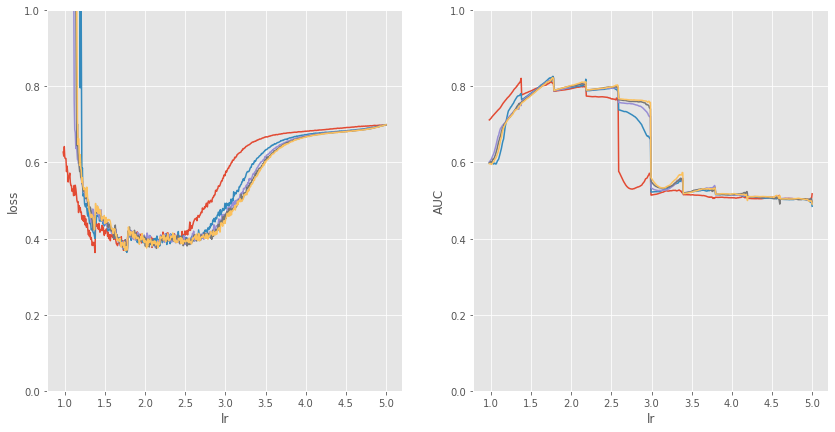

In [14]:
%matplotlib inline
mf.plot(True, lim=[0,1])

# fit one

In [25]:
%%time

batch_size = 8192
epochs = 100
nflod = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'binary_crossentropy',
               'use_linear': False}

clr = CyclicLR(base_lr=0.1**(3.5),
               max_lr = 0.1**(2.5), 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, mode='max', restore_best_weights=True)

fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[es, clr]}

model = fm(**model_param)

cv = CV(model, nflod)

score = cv.fit(x=[idx, val],
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 480000 samples, validate on 120000 samples
Epoch 1/100
480000/480000 [==============================] - 3s 6us/sample - loss: 0.6690 - AUC: 0.5038 - val_loss: 0.6307 - val_AUC: 0.5120
Epoch 2/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.5450 - AUC: 0.5201 - val_loss: 0.4686 - val_AUC: 0.6955
Epoch 3/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.4226 - AUC: 0.7561 - val_loss: 0.4062 - val_AUC: 0.7807
Epoch 4/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.3965 - AUC: 0.7927 - val_loss: 0.4042 - val_AUC: 0.7816
Epoch 5/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.3912 - AUC: 0.7989 - val_loss: 0.4039 - val_AUC: 0.7811
Epoch 6/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.3858 - AUC: 0.8056 - val_loss: 0.4043 - val_AUC: 0.7803
Epoch 7/100
480000/480000 [==============================] - 2s 4us/sample - loss: 0.3819 - AUC: 0.810

In [26]:
score

0.7828549629818887

# Tuning

In [27]:
%matplotlib qt5

batch_size = 8192
epochs = 100
nflod = 5

# fit param

clr = CyclicLR(base_lr=0.1**(3.5),
               max_lr = 0.1**(2.5), 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='exp_range',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=3,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam', 
                   'use_linear': False}

ss = {
    'loss': (hp.choice, ('binary_crossentropy', 'focal_loss')), 
    'k': (hp.choice, (5, 7, 8, 10)),
    'l1_pair': (hp.loguniform, (-20, 0)),
    'l2_pair': (hp.loguniform, (-20, 0))}

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=[idx, val],
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=2333,
                model=fm, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=100)

new best, eval 1, score -0.4982, param {'k': 8, 'l1_pair': 0.005589520648983362, 'l2_pair': 0.09662599966235999, 'loss': 'focal_loss'}
new best, eval 2, score -0.5362, param {'k': 10, 'l1_pair': 0.001471869173950627, 'l2_pair': 0.0017987509950809298, 'loss': 'focal_loss'}
new best, eval 3, score -0.7747, param {'k': 10, 'l1_pair': 3.756294487965603e-05, 'l2_pair': 7.891177973390504e-07, 'loss': 'focal_loss'}
new best, eval 7, score -0.7802, param {'k': 10, 'l1_pair': 2.461388284216056e-07, 'l2_pair': 5.548173748210683e-09, 'loss': 'focal_loss'}
new best, eval 8, score -0.7829, param {'k': 5, 'l1_pair': 4.453041844605923e-09, 'l2_pair': 5.556806546921976e-06, 'loss': 'binary_crossentropy'}
new best, eval 21, score -0.7846, param {'k': 7, 'l1_pair': 8.502671535109382e-07, 'l2_pair': 4.1941198121952895e-05, 'loss': 'binary_crossentropy'}
new best, eval 23, score -0.7857, param {'k': 7, 'l1_pair': 7.51269800820528e-07, 'l2_pair': 7.965454461608283e-05, 'loss': 'binary_crossentropy'}
new be

{'k': 2,
 'l1_pair': 1.3156522927933462e-07,
 'l2_pair': 0.00010767950961548223,
 'loss': 0}

In [28]:
log = tuning.log.get_log()

In [29]:
log.sort_values('score').head(20)

,score,update,usetime,k,l1_pair,l2_pair,loss
48,-0.786222,True,63.813922,8,1.315652e-07,1.076795e-04,binary_crossentropy
66,-0.786021,False,64.698304,8,8.712129e-08,1.181020e-04,binary_crossentropy
65,-0.786016,False,62.006688,8,3.264634e-08,8.435677e-05,binary_crossentropy
89,-0.785814,False,63.542084,8,3.435579e-06,7.468874e-05,binary_crossentropy
67,-0.785738,False,62.493188,8,4.872933e-09,1.329795e-04,binary_crossentropy
22,-0.785714,True,67.049643,7,7.512698e-07,7.965454e-05,binary_crossentropy
44,-0.785612,False,68.843987,8,2.739790e-08,8.669638e-05,binary_crossentropy
35,-0.785610,False,65.465260,7,1.202694e-05,4.541730e-08,binary_crossentropy
25,-0.785547,False,71.690121,7,1.227823e-06,2.159454e-04,binary_crossentropy
23,-0.785269,False,62.938405,7,1.964592e-06,2.041610e-04,binary_crossentropy


In [30]:
log.sort_values('score').tail(20)

,score,update,usetime,k,l1_pair,l2_pair,loss
30,-0.528304,False,88.966478,7,7.079924e-03,8.490706e-05,binary_crossentropy
52,-0.525437,False,47.247266,8,6.918144e-09,6.278654e-02,binary_crossentropy
19,-0.524965,False,61.730996,10,3.450984e-04,3.150535e-02,binary_crossentropy
75,-0.522247,False,54.728963,8,3.392851e-07,7.522398e-02,binary_crossentropy
58,-0.515107,False,32.504050,5,3.189416e-07,4.049844e-01,binary_crossentropy
31,-0.512546,False,48.663889,7,8.582583e-03,8.319567e-04,binary_crossentropy
9,-0.509973,False,32.693073,5,8.615512e-09,2.357388e-01,focal_loss
93,-0.508211,False,36.102841,8,1.227760e-07,1.325631e-01,focal_loss
17,-0.504341,False,34.175741,7,1.819847e-08,1.927827e-01,binary_crossentropy
8,-0.499599,False,39.360395,10,7.392796e-08,6.216282e-01,focal_loss


[-0.8, -0.75]
[-0.8, -0.75]
[-0.8, -0.75]
[-0.8, -0.75]


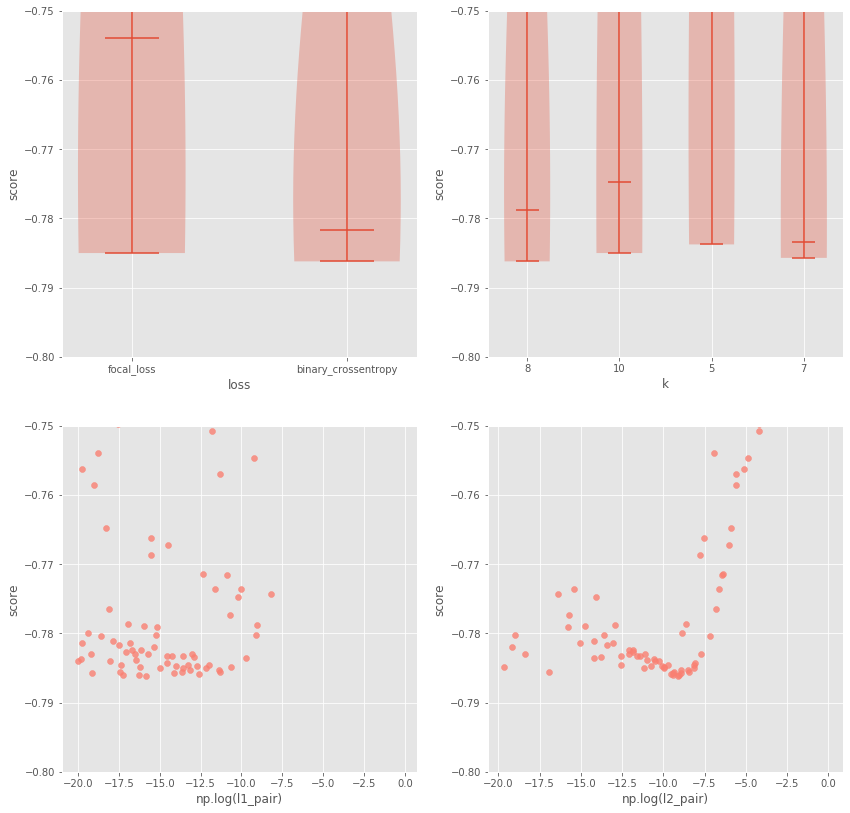

In [33]:
%matplotlib inline
tuning.log.plot(score_interval=[-0.8, -0.75])

In [34]:
np.random.randint(2**32)

3366580204

### 3366580204

In [36]:
log.to_csv('../tmp/fm/3366580204.csv', index=False)

In [37]:
batch_size = 8192
epochs = 400
nflod = 40
nmodel = 5

In [40]:
# model params
model_tuning_param = log.sort_values('score').head(nmodel).reset_index(drop=True).to_dict()

model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam',
                   'use_linear': False}

In [41]:
# callbacks
clr = CyclicLR(
    base_lr=1e-4,
    max_lr = 1e-3, 
    step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
    mode='triangular2',
    gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=3,
                                      mode='max',
                                      restore_best_weights=True)

# fit
fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

# Stacking 1

In [42]:
pred_lst = []
score_lst = []
pred_arr_lst = []

for i in range(nmodel):
    model_params = {}
    for param_name, param_value in model_fix_param.items():
        model_params[param_name] = param_value
        
    for param_name in model_tuning_param.keys():
        if param_name not in ['score', 'update', 'usetime', 'index']:
            model_params[param_name] = model_tuning_param[param_name][i]
            
    # cv
    model = fm(**model_params)
    cv = CV(model, nflod)
    
    score, pred_arr = cv.fit(x=[idx, val],
                             y=y_train, 
                             metrics_func=roc_auc_score,
                             split_method=StratifiedKFold,
                             fit_params=fit_param,
                             eval_param={'batch_size':batch_size},
                             use_proba=False, 
                             verbose=True,
                             fit_use_valid=True,
                             output_oof_pred=True)
    
    pred = cv.predict(x=[idx_test, val_test], pred_param={'batch_size': batch_size})
    
    pred_lst.append(pred)
    score_lst.append(score)
    pred_arr_lst.append(pred_arr)
    
    print('score: ', score)
    tf.keras.backend.clear_session()

folds 0 is done, score is 0.7806289567536696
folds 1 is done, score is 0.7868590327784882
folds 2 is done, score is 0.7881261666376905
folds 3 is done, score is 0.7836474492170851
folds 4 is done, score is 0.7880424806841719
folds 5 is done, score is 0.7875606511392274
folds 6 is done, score is 0.7878726697624334
folds 7 is done, score is 0.7861465629930607
folds 8 is done, score is 0.7861085318895769
folds 9 is done, score is 0.7806397497588442
folds 10 is done, score is 0.7855206855319634
folds 11 is done, score is 0.7971579111004554
folds 12 is done, score is 0.784802505239062
folds 13 is done, score is 0.7893425631491575
folds 14 is done, score is 0.7824715520335599
folds 15 is done, score is 0.7872336187009744
folds 16 is done, score is 0.7876682306738901
folds 17 is done, score is 0.7904529720577129
folds 18 is done, score is 0.792169483421944
folds 19 is done, score is 0.7931915912353904
folds 20 is done, score is 0.7863037114851829
folds 21 is done, score is 0.7844337904777128


folds 18 is done, score is 0.7910347135761342
folds 19 is done, score is 0.792757344384436
folds 20 is done, score is 0.7868308015484442
folds 21 is done, score is 0.7841793880999919
folds 22 is done, score is 0.7841845874367199
folds 23 is done, score is 0.7830347745661066
folds 24 is done, score is 0.7806932328237282
folds 25 is done, score is 0.785737947703786
folds 26 is done, score is 0.7917932909628284
folds 27 is done, score is 0.7776995686536778
folds 28 is done, score is 0.7945452589994093
folds 29 is done, score is 0.78375821261525
folds 30 is done, score is 0.7883588223513995
folds 31 is done, score is 0.7858883195323074
folds 32 is done, score is 0.7832000287657684
folds 33 is done, score is 0.7901258811999462
folds 34 is done, score is 0.7910015605020527
folds 35 is done, score is 0.7908909869673075
folds 36 is done, score is 0.7834672104121333
folds 37 is done, score is 0.7803945501468426
folds 38 is done, score is 0.7879110814784697
folds 39 is done, score is 0.781117103

In [43]:
pred_arr = np.array(pred_arr_lst).squeeze().T
np.save('../tmp/fm/3366580204stacking1.npy', pred_arr)
pred_arr.shape

(600000, 5)

In [44]:
pred = np.array(pred_lst).squeeze().T
np.save('../tmp/fm/3366580204predict.npy', pred)
pred.shape

(400000, 5)

In [45]:
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')
submission['target'] = np.mean(pred_lst, axis=0)
submission.to_csv('../tmp/submission/main_2_fm_3366580204.csv')

In [2]:
(0.7864932122415365+0.7865718790099054+0.78667992676747+0.786746609471493+0.7865768328381069)/5

0.7866136920657023